In [1]:
!pip install pydub


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [4]:
import torch
import IPython.display
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn.utils import resample
import librosa
import librosa.display
import os
import scipy.signal
import re
import sys


In [5]:
class ExtentionException(Exception):
    pass

class EmptyLabelException(Exception):
    pass
class RecordData:
  def __init__(self,record_data):
    self.record_data =record_data

  def pop_extend(self,get_num):
    tmp=[]
    while len(len(tmp)>get_num):
      tmp.append(self.pop())
    np.array(tmp)
    np.flipud(tmp)
    tmp = tmp[len(tmp)-(get_num+1):]
    return np.concatenate(tmp, 0)

  def push(self,push_data):
    return self.record_data.append(push_data)


class Segment:
    """
    a unit of speech (i.e. phoneme, mora)
    """
    def __init__(self, tStart, tEnd, label):
        self.tStart = tStart
        self.tEnd = tEnd
        self.label = label

    def __add__(self, other):
        return Segment(self.tStart, other.tEnd, self.label + other.label)

    def can_follow(self, other):
        """
        return True if Segment self can follow Segment other in one mora,
        otherwise return False
        example: (other, self)
             True: ('s', 'a'), ('sh', 'i'), ('ky', 'o:'), ('t', 's')
             False: ('a', 'q'), ('a', 's'), ('u', 'e'), ('s', 'ha')
        """
        vowels = ['a', 'i', 'u', 'e', 'o', 'a:', 'i:', 'u:', 'e:', 'o:']
        consonants = ['w', 'r', 't', 'y', 'p', 's', 'd', 'f', 'g', 'h', 'j',
                      'k', 'z', 'c', 'b', 'n', 'm']
        only_consonants = lambda x: all([c in consonants for c in x])
        if only_consonants(other.label) and self.label in vowels:
            return True
        if only_consonants(other.label) and only_consonants(self.label):
            return True
        return False

def read_lab(filename):
    """
    read label file (.lab) generated by Julius segmentation kit and
    return SegmentationLabel object
    """
    try:
        if not re.search(r'\.lab$', filename):
            raise ExtentionException("read_lab supports only .lab")
    except ExtentionException as e:
        print(e)
        return None

    with open(filename, 'r') as f:
        labeldata = [line.split() for line in f if line != '']
        segments = [Segment(tStart=float(line[0]), tEnd=float(line[1]),
                            label=line[2])
                    for line in labeldata]
        return SegmentationLabel(segments)

class SegmentationLabel:
    """
    list of segments
    """
    def __init__(self, segments, separatedByMora=False):
        self.segments = segments
        self.separatedByMora = separatedByMora
    def by_moras(self):
        """
        return new SegmentationLabel object whose segment are moras
        """
        if self.separatedByMora == True:
            return self

        moraSegments = []
        curMoraSegment = None
        for segment in self.segments:
            if curMoraSegment is None:
                curMoraSegment = segment
            elif segment.can_follow(curMoraSegment):
                curMoraSegment += segment
            else:
                moraSegments.append(curMoraSegment)
                curMoraSegment = segment
        if curMoraSegment:
            moraSegments.append(curMoraSegment)
        return SegmentationLabel(moraSegments, separatedByMora=True)

def read_wave_in_jvs(wave_path,label_path,sr,time_span=800):
  wave_data, _ = librosa.load(wave_path, sr=sr)
  label = read_lab(label_path)
  boin = ['a','i','u','e','o','a:','i:','u:','e:','o:']

  input_data = []
  input_label_data = []
  for seg in label.segments:
    if seg.label in boin:
      start = int(seg.tStart*sr)
      end = int(seg.tEnd*sr)
      if (end - start) <= time_span:
        continue
      tmp_wave = wave_data[start:end]
      wavelen = len(tmp_wave)
      for i in range(0,wavelen//time_span):
        tmp = tmp_wave[time_span*i:time_span*(i+1)]#0.05秒
        input_data.append(tmp)
        input_label_data.append(seg.label)


  return np.array(input_data,dtype=object),np.array(input_label_data,dtype=object)

def read_jvs(folder_num,sr,time_span=800):
  folder_path = 'data'
  wave_folder_path = os.path.join(folder_path,f"jvs{folder_num:03d}\parallel100\wav24kHz16bit")
  label_folder_path = os.path.join(folder_path,f"jvs{folder_num:03d}\parallel100\lab\mon")
  input_data=[]

  input_label_data=[]

  for i in range(1,101):
    filename = f"VOICEACTRESS100_{i:03d}"
    wave_path = os.path.join(wave_folder_path,filename+".wav")
    label_path = os.path.join(label_folder_path,filename+".lab")
    tmp_data,tmp_label=read_wave_in_jvs(wave_path,label_path,sr,time_span)
    print(str(i)+":"+str(tmp_data.shape))
    if(tmp_data.shape[0]!=0):
      input_data.append(tmp_data)
      input_label_data.append(tmp_label)
  input_data = np.concatenate(input_data)
  input_label_data = np.concatenate(input_label_data)
  return np.array(input_data,dtype=object),np.array(input_label_data,dtype=object)

def cep(audio,frame_len=512,hop_len=256,dim=50):
  # 窓関数の設定
  window = np.hamming(frame_len)
  # フレームごとにケプストラム解析を行う
  log_data=[]
  cepstrum_data =[]
  origin_data = []
  for wave in audio:
    cepstrum = []
    tmp = []
    log_tmp=[]
    for i in range(0, len(wave)-hop_len, hop_len):
      if i+frame_len > len(wave):
        break
      # 窓関数をかける
      frame = wave[i:i+frame_len] * window
      tmp.append(frame)
      # フーリエ変換
      spectrum = np.fft.fft(frame)
      # 対数振幅スペクトル
      log_spectrum = np.log(np.abs(spectrum))
      log_tmp.append(log_spectrum)
      # 逆フーリエ変換
      ceps = np.fft.ifft(log_spectrum)
      ceps[dim:len(ceps)-dim]=0
      # ケプストラムのリストに追加
      cepstrum.append(ceps)
    log_data.append(log_tmp)
    origin_data.append(tmp)
    cepstrum_data.append(cepstrum)
  # ケプストラムの配列に変換
  cepstrum_data = np.array(cepstrum_data)
  # 声道スペクトルの抽出
  vocal_tract_spectrum = np.exp(np.real(cepstrum_data))
  origin_data = np.array(origin_data)
  log_data=np.array(log_data)
  print(log_data.shape)
  print(vocal_tract_spectrum.shape)
  print(origin_data.shape)

  # 声道スペクトルからケプストラムへ変換
  tmp = np.log(vocal_tract_spectrum)

  # ケプストラムから対数振幅スペクトルへ変換
  log_spectrum = np.fft.fft(tmp)
  half_index = log_spectrum.shape[2]//2
  log_spectrum = log_spectrum.real[:,:,0:half_index]
  print(log_spectrum.shape)
  fo = []
  fo_onehot = []
  for i,wave_data in enumerate(log_spectrum):
    tmp = []
    fo_tmp = []
    for j,data in enumerate(wave_data):
      fo_tmp2 = np.zeros(256)
      max_index = scipy.signal.argrelmax(data, order=3)
      max_index = max_index[0]
      tmp.append(max_index)
      for k in range(4):
        if 0<=k and k<len(max_index):
          fo_tmp2[max_index[k]]=1
      fo_tmp.append(fo_tmp2)
    fo_onehot.append(fo_tmp)
    fo.append(tmp)
  fo = np.array(fo)
  fo_onehot = np.array(fo_onehot)
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1, 1, 1)
  frame = np.random.randint(0,log_spectrum.shape[0])
  ax.plot(log_spectrum[frame][0][0:log_spectrum.shape[2]])
  ax.axvline(fo[frame][0][0], ls = "--", color = "navy")
  ax.axvline(fo[frame][0][1], ls = "--", color = "navy")
  ax.axvline(fo[frame][0][2], ls = "--", color = "navy")
  ax.axvline(fo[frame][0][3], ls = "--", color = "navy")
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.title(f'Waveform of frame {frame}')
  plt.show()
  plt.figure(figsize=(10, 6))
  plt.plot(log_data[frame][0][0:log_spectrum.shape[2]])
  plt.show()
  return log_spectrum,fo_onehot,fo

In [6]:
sr = 16000
data = []
label = []
no_label=[6,28,30,37,58,74,89]
for i in range(1,3):
  if i in no_label:
    continue
  tmp_data,tmp_label = read_jvs(i,16000,3072)
  print(str(i)+":"+str(len(tmp_data)))
  data.append(tmp_data)
  label.append(tmp_label)

data = np.concatenate(data)
label = np.concatenate(label)
print(data.shape)




# 入力データを増量



1:(2, 3072)
2:(1, 3072)
3:(1, 3072)
4:(1, 3072)
5:(1, 3072)
6:(0,)
7:(1, 3072)
8:(2, 3072)
9:(0,)
10:(1, 3072)
11:(1, 3072)
12:(0,)
13:(2, 3072)
14:(0,)
15:(0,)
16:(1, 3072)
17:(2, 3072)
18:(0,)
19:(1, 3072)
20:(2, 3072)
21:(3, 3072)
22:(0,)
23:(0,)
24:(1, 3072)
25:(0,)
26:(0,)
27:(1, 3072)
28:(1, 3072)
29:(2, 3072)
30:(0,)
31:(1, 3072)
32:(3, 3072)
33:(0,)
34:(0,)
35:(3, 3072)
36:(2, 3072)
37:(0,)
38:(2, 3072)
39:(0,)
40:(1, 3072)
41:(1, 3072)
42:(0,)
43:(0,)
44:(2, 3072)
45:(1, 3072)
46:(2, 3072)
47:(1, 3072)
48:(1, 3072)
49:(0,)
50:(0,)
51:(1, 3072)
52:(2, 3072)
53:(0,)
54:(0,)
55:(0,)
56:(2, 3072)
57:(0,)
58:(0,)
59:(0,)
60:(1, 3072)
61:(0,)
62:(0,)
63:(0,)
64:(1, 3072)
65:(1, 3072)
66:(1, 3072)
67:(0,)
68:(0,)
69:(0,)
70:(0,)
71:(0,)
72:(0,)
73:(2, 3072)
74:(0,)
75:(1, 3072)
76:(2, 3072)
77:(0,)
78:(1, 3072)
79:(3, 3072)
80:(0,)
81:(1, 3072)
82:(0,)
83:(4, 3072)
84:(0,)
85:(2, 3072)
86:(2, 3072)
87:(1, 3072)
88:(1, 3072)
89:(1, 3072)
90:(1, 3072)
91:(0,)
92:(3, 3072)
93:(2, 3072)


In [7]:
boin = ['a','i','u','e','o','a:','i:','u:','e:','o:']
data = np.array(data,dtype="float64")
for i,l in enumerate(label):
  label[i] = boin.index(l)%5
  print(l)
label = np.array(label,dtype="int64")


a
o
o
a
a
e
o
o
o
o
e
a
e
o
o
o
o
o
o
o
e
o
o
o
e
o
i
e
o
o
o
o
i
o
o
e
i
e
e
a
e
i
a
o
e
e
o
e
o
u
a
o
o
o
u
e
e
o
o
o
o
o
o
o
o
o
o
i
a
o
o
i
e
a
o
u
e
o
o
o
o
e
o
e
o
o
e
o
o
a
a
o
e
o
o
o
o
o
e
a
a
o
o
o
e
o
o
e
a
o
e
i
e
i
o
o
i
e
o
u
a
o


In [8]:
# 各クラスの数をカウント
class_counts = np.bincount(label)
for cnt in class_counts:
  print(cnt)
# 最少のクラス数を取得
min_class_count = np.min(class_counts)

# 各クラスごとにサンプリング数を均等化
balanced_data = []
balanced_label = []

for class_label in np.unique(label):
    class_indices = np.where(label == class_label)[0]
    balanced_indices = resample(class_indices, n_samples=min_class_count, random_state=42)

    balanced_data.extend(data[balanced_indices])
    balanced_label.extend(label[balanced_indices])

balanced_data = np.array(balanced_data)
balanced_label = np.array(balanced_label)

print(balanced_label.shape)
print(label[0])

15
9
4
27
67
(20,)
0


In [10]:
pitch_shifted_label = []
pitch_shifted_data = []
pitch_ran = np.arange(-3,3,0.1)

for n,audio in enumerate(balanced_data):
  for i in pitch_ran:
    audio=audio.astype(np.float32)
    shifted = librosa.effects.pitch_shift(audio, sr=16000, n_steps=i)  # ピッチを上げる
    pitch_shifted_data.append(shifted)
    pitch_shifted_label.append(balanced_label[n])

In [ ]:
np.savetxt('augmented_data.csv', data, delimiter=',')
np.savetxt('augmented_label.csv',label, delimiter=',')

In [ ]:
data=np.loadtxt('augmented_data.csv', delimiter=',')
label=np.loadtxt('augmented_label.csv', delimiter=',')


In [ ]:
print(balanced_label[0])

0


In [11]:
augmented_data = pitch_shifted_data
augmented_label = pitch_shifted_label

In [12]:
#input_dim = 80  # メルスペクトログラムの次元数

#n_fft = 800
#hop_length = 160



# augmented_dataの音声データを順番に再生
augmented_data = np.array(augmented_data)
augmented_label = np.array(augmented_label)
print(augmented_data.shape)
print(augmented_label.shape)
number = 0
print(augmented_label[number])
IPython.display.Audio(augmented_data[number], rate=16000)


(1200, 3072)
(1200,)
0


(900, 11, 512)
(900, 11, 512)
(900, 11, 512)
(900, 11, 256)


<ipython-input-4-33e105f99f08>:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fo = np.array(fo)


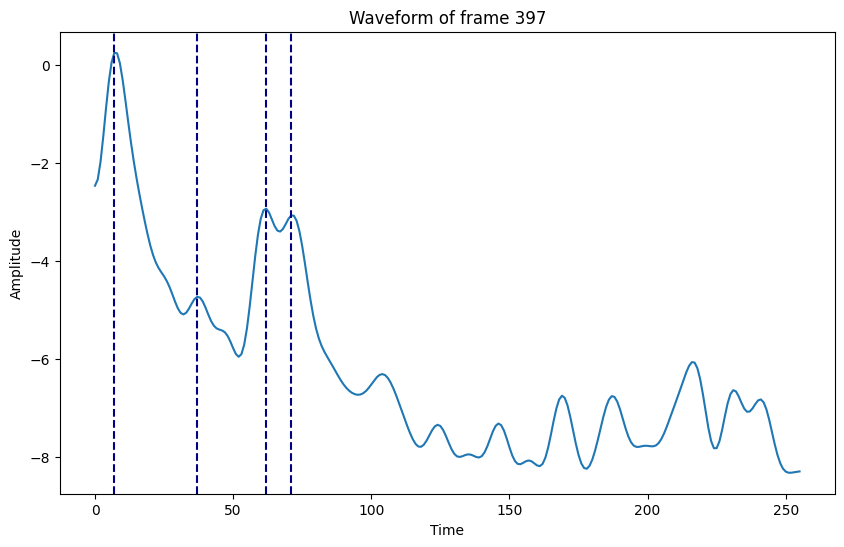

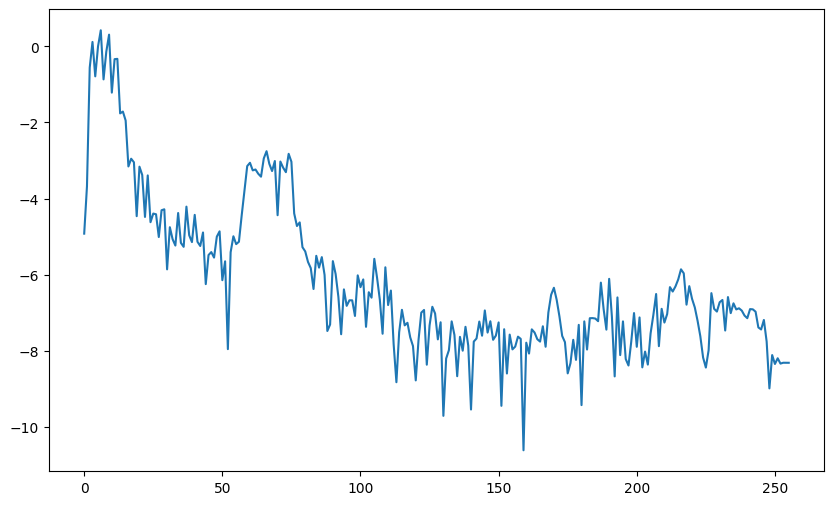

In [ ]:
log_spectrum,fo_onehot,_ = cep(augmented_data)

In [13]:
from torch.utils.data.dataset import random_split
# メルスペクトログラムの抽出
mel_data = []
input_dim = 64
n_fft = 512
hop_length = 256
n_mels = input_dim

print(augmented_data.shape)
for audio in augmented_data:
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,center=False)
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    mel_data.append(log_mel_spec)
def normal(x):

  x_scaled = (x-x.min())/(x.max()-x.min())

  return x_scaled
np_meldata = np.array(mel_data)
print(np_meldata.shape)

(1200, 3072)
(1200, 64, 11)


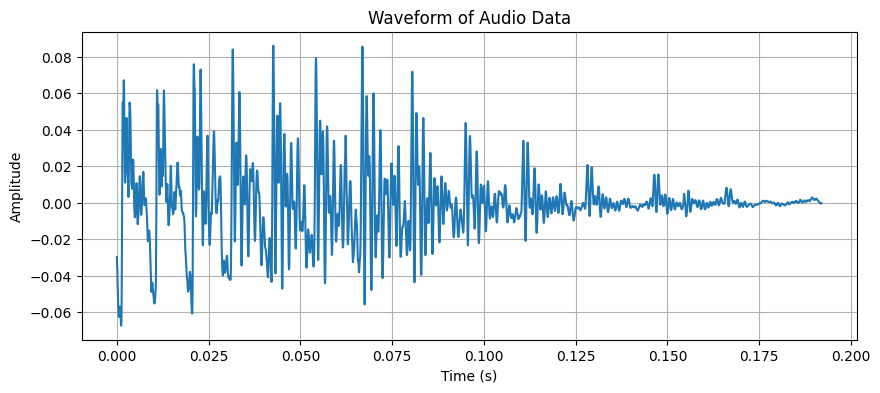

In [14]:
# サンプリングレートとサンプル数を指定
sample_rate = 16000  # サンプリングレート (Hz)
num_samples = 3072  # サンプル数

# サンプルデータを生成（仮のデータとしてランダムな値を使用）
# ここで、実際の音声データを使用する場合は、適切な方法で読み込んでください。
audio_data = augmented_data[0]

# サンプル数を時間に変換
time = np.arange(0, num_samples) / sample_rate

# 波形グラフをプロット
plt.figure(figsize=(10, 4))
plt.plot(time, audio_data)
plt.title('Waveform of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

1200
960


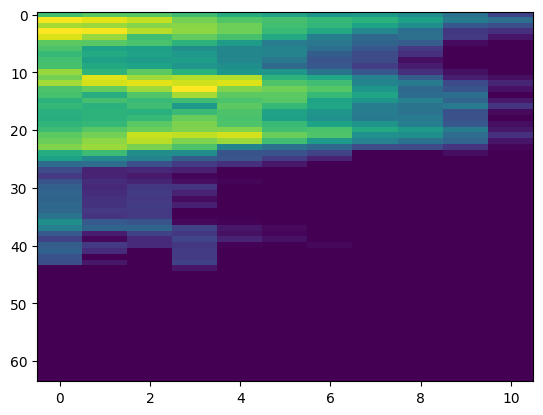

In [15]:


# 特徴量:メルスペクトログラム
x_size = np_meldata.shape[1]
y_size = np_meldata.shape[2]
fig, axs = plt.subplots(1,1)
axs.imshow(np_meldata[1],aspect="auto")

dataset_mean=0
dataset_std=0

dataset_mean = np_meldata.mean()
l2 = np_meldata - dataset_mean

dataset_std = l2.std()
np_meldata = l2/dataset_std

np_meldata = normal(np_meldata)
batch_size = 20

# データセット作成
np_meldata = np_meldata[:,np.newaxis,:,:]

X = torch.tensor(np_meldata,dtype=torch.float32)
Y = torch.tensor(augmented_label,dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(X,Y)

train_size = int(0.8*len(dataset))
eval_size = len(dataset)-train_size
print(train_size+eval_size)
train_dataset,eval_dataset = torch.utils.data.random_split(dataset,[train_size,eval_size])
print(len(train_dataset))

dataloader_train =  torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=0
)
dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=300,
    shuffle=True,
    num_workers=0
)


9000
7200


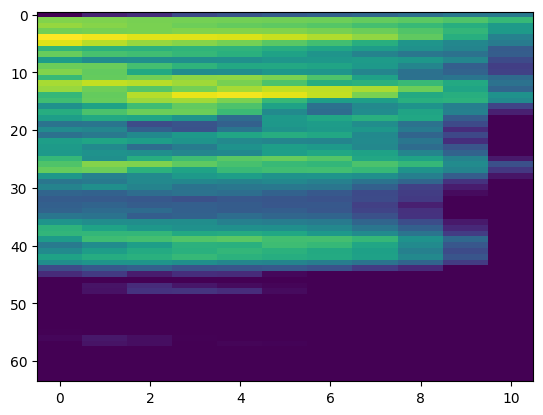

In [ ]:
# 特徴量:メルスペクトログラム
x_size = np_meldata.shape[1]
y_size = np_meldata.shape[2]
fig, axs = plt.subplots(1,1)
axs.imshow(mel_data[1],aspect="auto")
np_meldata = normal(np_meldata)
batch_size = 20

# データセット作成
np_meldata = np_meldata[:,np.newaxis,:,:]

X = torch.tensor(np_meldata,dtype=torch.float32)
Y = torch.tensor(augmented_label,dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(X,Y)

train_size = int(0.8*len(dataset))
eval_size = len(dataset)-train_size
print(train_size+eval_size)
train_dataset,eval_dataset = torch.utils.data.random_split(dataset,[train_size,eval_size])
print(len(train_dataset))

dataloader_train =  torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=0
)
dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=300,
    shuffle=True,
    num_workers=0
)


In [16]:
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim):
      super(VAE, self).__init__()
      self.x_dim = x_dim
      self.z_dim = z_dim
      self.fc1 = nn.Linear(x_dim, 20)
      self.bn1 = nn.BatchNorm1d(20)
      self.fc2_mean = nn.Linear(20, z_dim)
      self.fc2_var = nn.Linear(20, z_dim)

      self.fc3 = nn.Linear(z_dim, 20)
      self.drop1 = nn.Dropout(p=0.2)
      self.fc4 = nn.Linear(20, x_dim)

    def encoder(self, x):
      x = x.view(-1, self.x_dim)
      x = F.relu(self.fc1(x))
#      x = self.bn1(x)
      mean = self.fc2_mean(x)
      log_var = self.fc2_var(x)
      return mean, log_var

    def sample_z(self, mean, log_var, device):
      epsilon = torch.randn(mean.shape, device=device)
      return mean + epsilon * torch.exp(0.5*log_var)

    def decoder(self, z):
      y = F.relu(self.fc3(z))
      y = self.drop1(y)
      y = torch.sigmoid(self.fc4(y))
      return y

    def forward(self, x, device):
      x = x.view(-1, self.x_dim)
      mean, log_var = self.encoder(x)
      delta = 1e-8
      KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))
      z = self.sample_z(mean, log_var, device)
      y = self.decoder(z)
      # 本来はmeanだがKLとのスケールを合わせるためにsumで対応
      reconstruction = torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))
      lower_bound = [KL, reconstruction]
      return -sum(lower_bound), z, y

In [17]:
num_epochs = 100
device = torch.device("cuda")

In [21]:
import torch
print(torch.cuda.is_available())

True


EPOCH: 0 loss: 47058.0078125
EPOCH: 1 loss: 45608.8046875
EPOCH: 2 loss: 43536.4921875
EPOCH: 3 loss: 40462.05859375
EPOCH: 4 loss: 37098.8203125
EPOCH: 5 loss: 33775.90625
EPOCH: 6 loss: 31301.91796875
EPOCH: 7 loss: 29585.40234375
EPOCH: 8 loss: 28356.8125
EPOCH: 9 loss: 27607.037109375
EPOCH: 10 loss: 27012.193359375
EPOCH: 11 loss: 26593.349609375
EPOCH: 12 loss: 26313.51953125
EPOCH: 13 loss: 25973.23828125
EPOCH: 14 loss: 25844.18359375
EPOCH: 15 loss: 25633.337890625
EPOCH: 16 loss: 25485.40625
EPOCH: 17 loss: 25340.166015625
EPOCH: 18 loss: 25211.400390625
EPOCH: 19 loss: 25100.857421875
EPOCH: 20 loss: 24939.419921875
EPOCH: 21 loss: 24826.375
EPOCH: 22 loss: 24719.068359375
EPOCH: 23 loss: 24492.41796875
EPOCH: 24 loss: 24386.3359375
EPOCH: 25 loss: 24234.27734375
EPOCH: 26 loss: 24110.9375
EPOCH: 27 loss: 23993.47265625
EPOCH: 28 loss: 23901.71875
EPOCH: 29 loss: 23807.74609375
EPOCH: 30 loss: 23707.26171875
EPOCH: 31 loss: 23582.78125
EPOCH: 32 loss: 23505.751953125
EPOCH: 

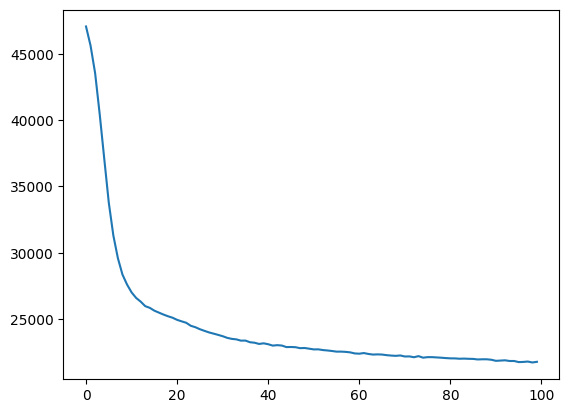

In [19]:
model = VAE(x_dim=x_size*y_size, z_dim=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      loss, z, y = model(x, device)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

plt.plot(loss_list)

plt.show()

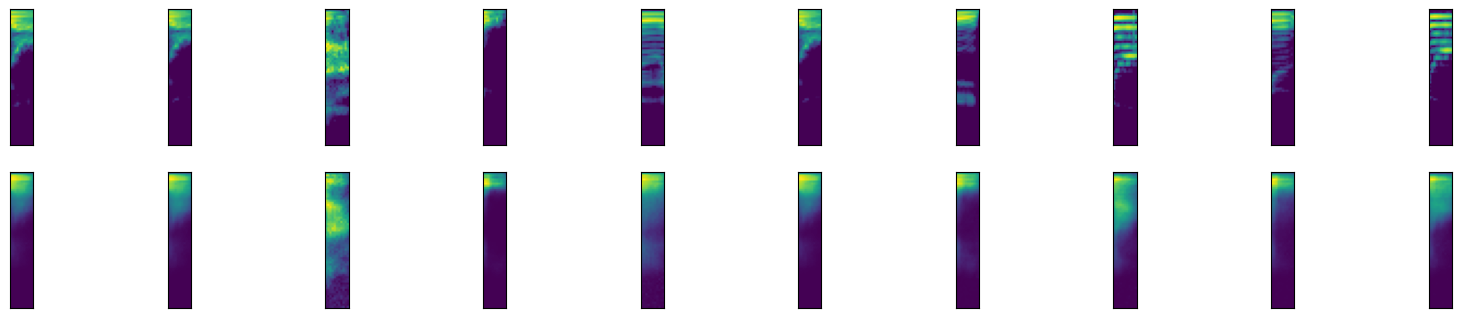

In [20]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1, x_size, y_size).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im)

    x = x.to(device)
    tmp, z, y = model(x,device)
    zs.append(z)
    y = y.view(-1, x_size, y_size)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im)

    break

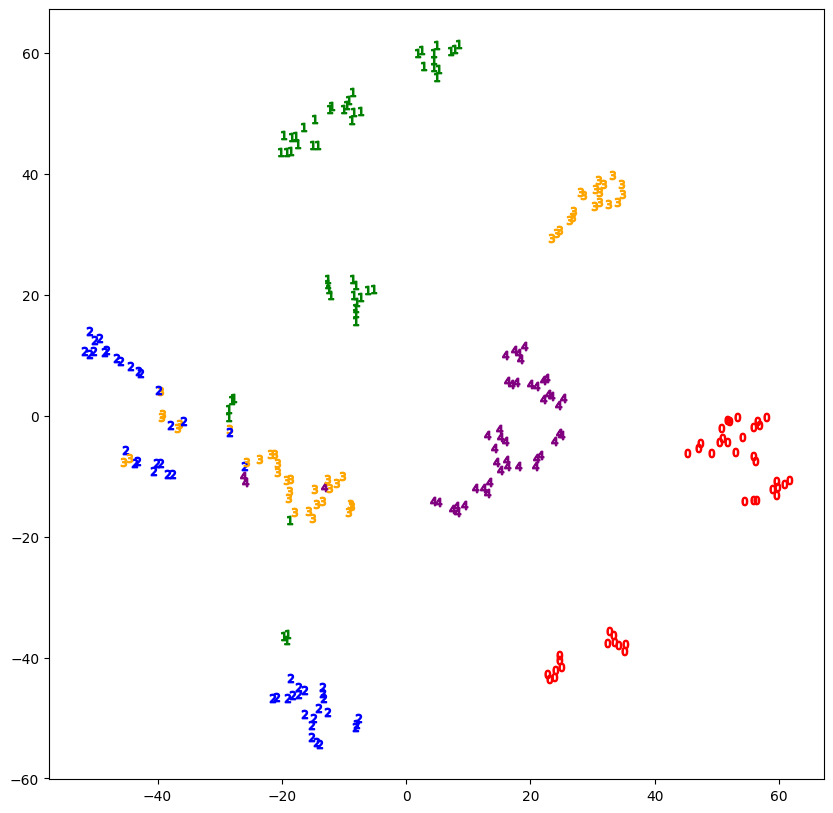

In [21]:
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0,perplexity=5).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
for x, t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break

In [22]:
model = VAE(x_dim=x_size*y_size, z_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      loss, z, y = model(x, device)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

plt.plot(loss_list)

plt.show()

EPOCH: 0 loss: 47266.890625
EPOCH: 1 loss: 46206.8671875
EPOCH: 2 loss: 45206.4453125
EPOCH: 3 loss: 43776.62890625
EPOCH: 4 loss: 41576.3984375
EPOCH: 5 loss: 38375.58203125
EPOCH: 6 loss: 35101.94921875
EPOCH: 7 loss: 32487.23046875
EPOCH: 8 loss: 30853.587890625
EPOCH: 9 loss: 29592.630859375
EPOCH: 10 loss: 28764.306640625
EPOCH: 11 loss: 27978.90234375
EPOCH: 12 loss: 27372.42578125
EPOCH: 13 loss: 26873.994140625
EPOCH: 14 loss: 26452.05078125
EPOCH: 15 loss: 25998.40625
EPOCH: 16 loss: 25543.20703125
EPOCH: 17 loss: 25271.60546875
EPOCH: 18 loss: 25002.28515625
EPOCH: 19 loss: 24839.47265625
EPOCH: 20 loss: 24655.1640625
EPOCH: 21 loss: 24475.6796875
EPOCH: 22 loss: 24343.47265625
EPOCH: 23 loss: 24160.44921875
EPOCH: 24 loss: 24136.77734375
EPOCH: 25 loss: 24028.3125
EPOCH: 26 loss: 23861.51171875
EPOCH: 27 loss: 23845.61328125
EPOCH: 28 loss: 23755.82421875
EPOCH: 29 loss: 23708.19140625
EPOCH: 30 loss: 23590.515625
EPOCH: 31 loss: 23552.025390625
EPOCH: 32 loss: 23512.9414062

[3 3 3 2 3 3 1 4 3 0]


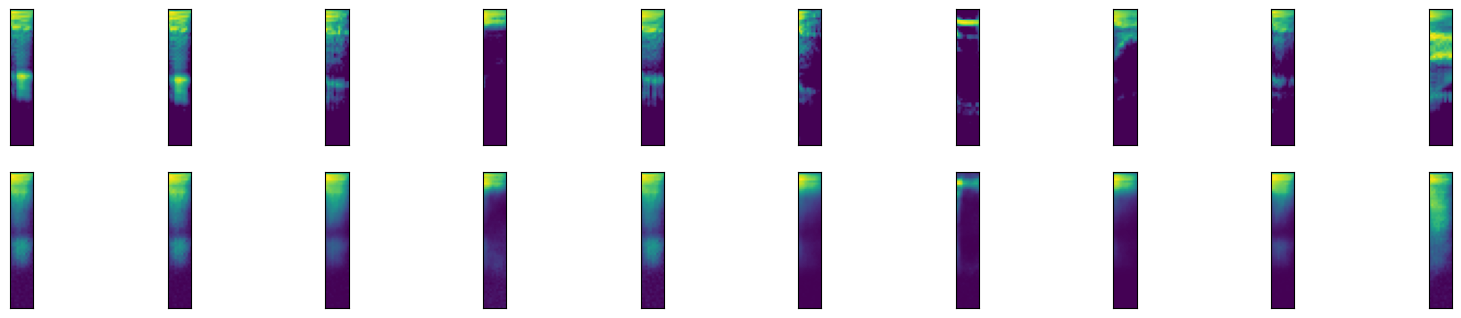

In [22]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    print(t.detach().numpy()[:10])
    for i, im in enumerate(x.view(-1, x_size, y_size).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im)

    x = x.to(device)
    tmp, z, y = model(x,device)
    zs.append(z)
    y = y.view(-1, x_size, y_size)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im)
    break

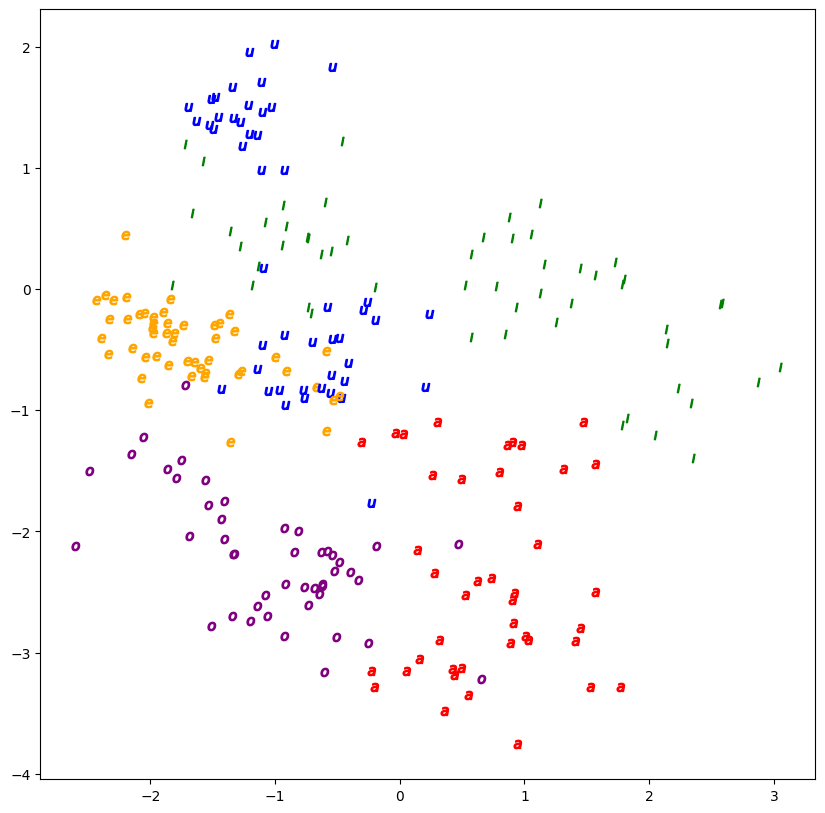

(1, 240, 3)
(1, 240)


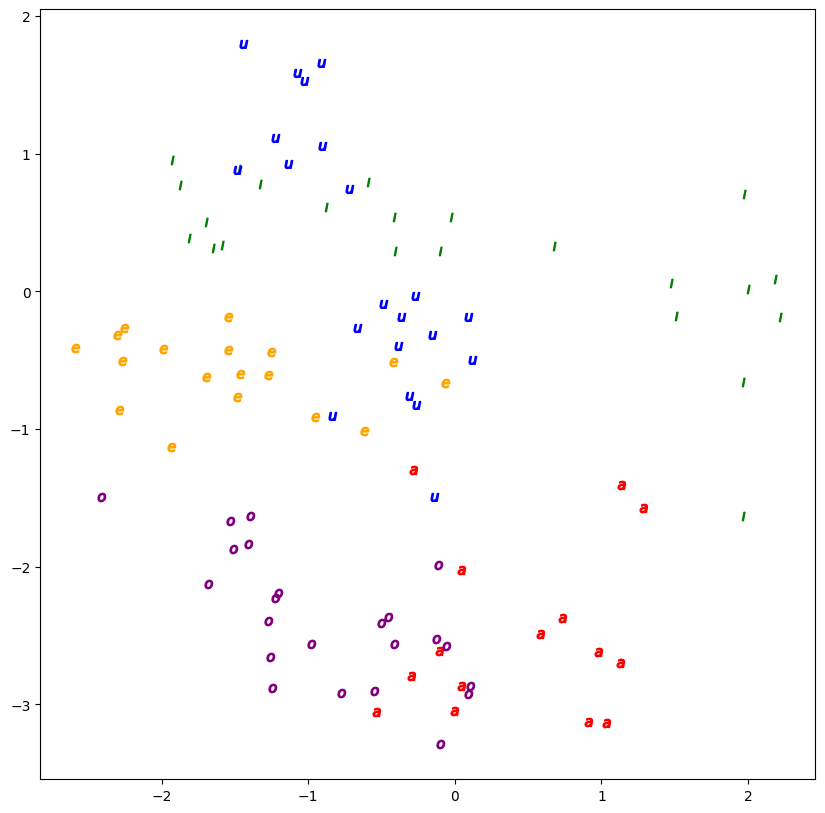

In [25]:
from sklearn.manifold import TSNE
from random import random


labeltoword = ["a","i","u","e","o","a:","i:","u:","e:","o:"]
colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = zs
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
  plt.show()

model.eval()
zs = []

dataloader_valid =  torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=1000,
    shuffle=True,
    num_workers=0
)
data = []
label = []
cnt = 0
for x, t in dataloader_valid:
    if cnt>2:
      break
    x = x.to(device)
    t = t.to(device)

    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    data.append(z.detach().numpy())
    label.append(t.detach().numpy())
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    cnt = cnt+1
data = np.array(data)
label = np.array(label)
print(data.shape)
print(label.shape)
for x, t in dataloader_train:

    x = x.to(device)
    t = t.to(device)
    # generate from x
    tmp, z, y = model(x,device)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break

In [25]:
from sklearn.neighbors import KNeighborsClassifier
k = 3  # kの値を設定（近傍の数）
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(data[0], label[0])
predicted_labels = knn.predict(data[1])
count = 0
for i,pre in enumerate(predicted_labels):
  if pre == label[1][i]:
    count = count+1
acc = (count/len(label[1]))
print("acc:"+str(acc))
print(data[0].shape)
print(data[1].shape)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [24]:
import threading
import time
import queue
import pyaudio
import sys

# スレッドAでマイクから音声データを取得する関数
def audio_capture_thread(q):
    print("threadA")
    CHUNK = 1024  # 音声データのチャンクサイズ
    FORMAT = pyaudio.paInt16  # 音声データのフォーマット
    CHANNELS = 1  # モノラル
    RATE = 16000  # サンプリングレート

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    output=True,
                    frames_per_buffer=CHUNK)

    buffer = []  # データを一時的に格納するバッファ

    while not exit_event.is_set():
        data = stream.read(CHUNK)
        buffer.extend(data)
        output = stream.write(data)
        # バッファが3072サンプルに達したら、キューに追加
        if len(buffer) >= 3072:
            q.put(buffer[:3072])  # 3072サンプルをキューに追加
            buffer = buffer[3072:]

    stream.stop_stream()
    stream.close()
    p.terminate()
z_tmp=[]
# スレッドBでデータを取得して関数Cに渡す関数
def process_data_thread(q, c_func):
    global z
    print("threadB")
    model.eval()
    fig =plt.figure(figsize=(10,10))
    ax=fig.add_subplot(1,1,1)
    while not exit_event.is_set():
        try:
            
            audio_data = q.get(timeout=1.0)  # キューから最新の音声データを取得（1秒ごと）
            audio_data = np.array(audio_data,dtype="int16")/32768
            mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,center=False)
            log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
            l2 = log_mel_spec - dataset_mean
            np_meldata = l2/dataset_std
            np_meldata = normal(np_meldata)
            tensor_meldata =torch.from_numpy(np_meldata.astype(np.float32)).clone()
            x = tensor_meldata.to(device)
            tmp,z,y=model(x,device)
            z = z.cpu().detach().numpy()
            z = z[0]
            z_tmp.append(z)
        except queue.Empty:
            pass

# 関数C：音声データを処理するサンプル関数
def process_audio_data(data):
    print(len(data))
    # ここで音声データを処理する（例: 波形データを解析する）
    pass

def keyboard_input_thread():
    global exit_event
    print("end")
    input("Press Enter to exit...")
    exit_event.set()

threadA
threadB
sleep


TypeError: scatter() missing 1 required positional argument: 'y'

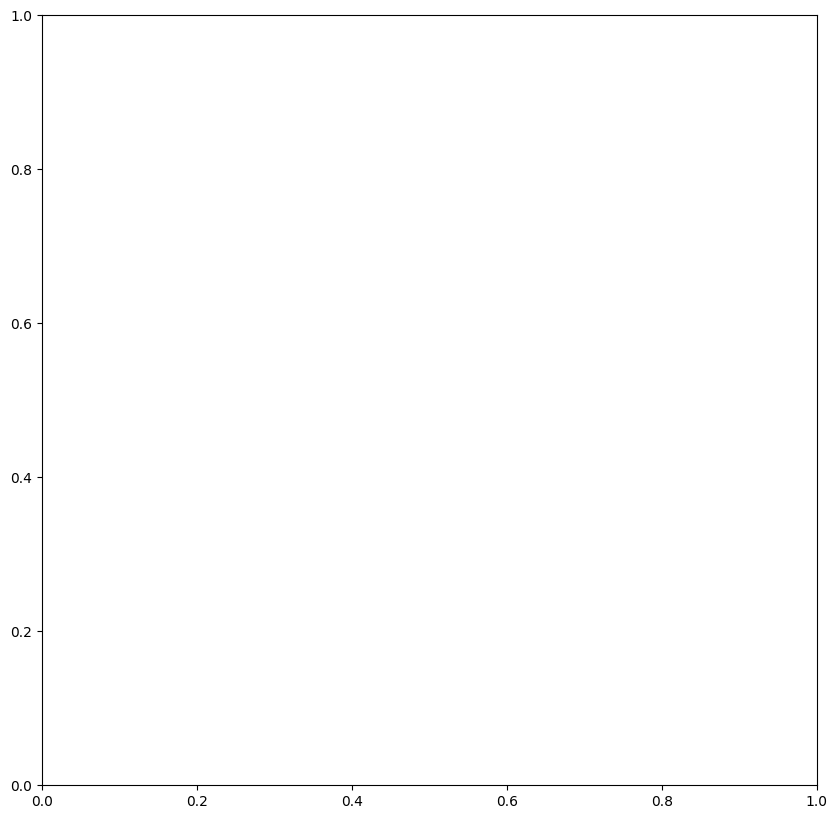

<Figure size 1000x1000 with 0 Axes>

In [26]:
exit_event = threading.Event()
data_queue = queue.Queue()

# キーボード入力を監視するスレッドを開始
keyboard_thread = threading.Thread(target=keyboard_input_thread)
keyboard_thread.daemon = True
#keyboard_thread.start()

# スレッドAを開始
audio_thread = threading.Thread(target=audio_capture_thread, args=(data_queue,))
audio_thread.daemon = True
audio_thread.start()

# スレッドBを開始
process_thread = threading.Thread(target=process_data_thread, args=(data_queue, process_audio_data))
process_thread.daemon = True
process_thread.start()


print("sleep")
time.sleep(10)  # プログラムを10秒間実行
plt.figure(figsize=(10,10))
plt.scatter(z_tmp)
plt.show()
exit_event.set()  # 10秒経過後、プログラムを終了

# すべてのスレッドの終了を待つ
#keyboard_thread.join()
audio_thread.join()
process_thread.join()


In [52]:

def realtime_recording():
    CHUNK = 1024  # 音声データのチャンクサイズ
    FORMAT = pyaudio.paInt16  # 音声データのフォーマット
    CHANNELS = 1  # モノラル
    RATE = 16000  # サンプリングレート

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    output=True,
                    frames_per_buffer=CHUNK)
    return p, stream
def stop_recording(audio, stream):
    stream.stop_stream()
    stream.close()
    audio.terminate()

def read_plot_data(stream,ax):
    audio_data = stream.read(3072)
    audio_data = np.frombuffer(audio_data, dtype='int16')/32768
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,center=False)
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    l2 = log_mel_spec - dataset_mean
    np_meldata = l2/dataset_std
    np_meldata = normal(np_meldata)
    tensor_meldata =torch.from_numpy(np_meldata.astype(np.float32)).clone()
    x = tensor_meldata.to(device)
    tmp,z,y=model(x,device)
    z = z.cpu().detach().numpy()
    z = z[0]
    
    print(z)
    points = data[0]
    
    for p, l in zip(points, label[0]):
        ax.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
    ax.scatter(z[0],z[1], c="pink", alpha=0.5, linewidths=2,
        edgecolors="red")
    plt.draw()
    plt.pause(0.0001)
    plt.cla()
    

In [53]:
%matplotlib
(audio,stream) = realtime_recording()
    
fig =plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
for i in range(0,50):
    read_plot_data(stream,ax)
      


stop_recording(audio,stream)

Using matplotlib backend: TkAgg
[0.5102311  0.48715448]


TypeError: _AxesBase.draw() missing 1 required positional argument: 'renderer'

In [ ]:
from pyqtgraph.Qt import QtGui, QtCore
import numpy as np
import pyqtgraph as pg
import time
from PyQt6 import QtWidgets  

app = QtWidgets.QApplication([])#　PyQtのアプリ生成
win = pg.GraphicsLayoutWidget() # GraphicsWindow() オブジェクト生成
win.resize(500, 500)
win.show()

p = win.addPlot(title="real-time scatter plot") # PlotItem オブジェクト生成
curve = p.plot(pen=None, symbol="o", symbolPen='b', symbolSize=10, symbolBrush='c') # PlotDataItemオブジェクト生成。pen=Noneで点のみ
pg.setConfigOptions(antialias=True)

n_data = 1000
x = np.random.normal(0.0, 1.0, n_data)
y = np.random.normal(0.0, 1.0, n_data)
p.setXRange(-5, 5)
p.setYRange(-5, 5)

iter = 0
pretime = time.time()
def update():
    global iter, p, x, y, curve
    global pretime
    
    # x, y座標を変更（アニメーション）
    x += np.random.normal(0.0, 0.1, n_data) + 0.01*np.cos(2*np.pi*iter/300)
    y += np.random.normal(0.0, 0.1, n_data) + 0.01*np.sin(2*np.pi*iter/120)

    if iter > 0:
        p.enableAutoRange('xy', False) # x, y軸のスケール固定
    curve.setData(x, y)
    curve.setAlpha(0.5, False)
    
    curtime = time.time()
    fps = 1.0 / (curtime - pretime + 1e-16)
    p.setTitle(f"fps: {fps:0.1f} Hz")
    pretime = curtime
    iter += 1
    
fps = 60
timer = QtCore.QTimer()
timer.timeout.connect(update)
timer.start(0.01)
app.exec_()

In [101]:
def get_default_microphone_info():
    try:
        p = pyaudio.PyAudio()
    except Exception as e:
        print(f"Error creating PyAudio instance: {e}")
        return None

    default_device_index = p.get_default_input_device_info()["index"]
    microphone_info = p.get_device_info_by_index(default_device_index)
    p.terminate()
    return microphone_info
microphone_info = get_default_microphone_info()

if microphone_info:
    print("Default Microphone Info:")
    print(f"Device Index: {microphone_info['index']}")
    print(f"Device Name: {microphone_info['name']}")
    print(f"Sample Rate: {microphone_info['defaultSampleRate']} Hz")
    print(f"Input Channels: {microphone_info['maxInputChannels']}")
    print(f"Output Channels: {microphone_info['maxOutputChannels']}")

Default Microphone Info:
Device Index: 1
Device Name: 繝槭う繧ｯ (Logicool G935/G933s Gaming
Sample Rate: 44100.0 Hz
Input Channels: 1
Output Channels: 0


In [ ]:
!sudo apt-get install -q -y timidity libsndfile1
!pip install pydub librosa music21

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.31-2build1).
The following additional packages will be installed:
  fluid-soundfont-gm libao-common libao4
Suggested packages:
  fluid-soundfont-gs libaudio2 libsndio6.1 freepats pmidi timidity-daemon
The following NEW packages will be installed:
  fluid-soundfont-gm libao-common libao4 timidity
0 upgraded, 4 newly installed, 0 to remove and 18 not upgraded.
Need to get 130 MB of archives.
After this operation, 151 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fluid-soundfont-gm all 3.1-5.3 [130 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao4 amd64 1.2.2+20180113-1.1ubuntu3 [35.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 timidity amd64 2.14.0-8ubuntu1 [683 

In [ ]:
!pip install pydub
!pip install audio2numpy


In [21]:
import tensorflow as tf
import tensorflow_hub as hub
import pydub
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay
from threading import Thread, Lock
import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile
import threading
import time
from base64 import b64decode

import music21
import struct
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.13.0


In [49]:

import random
for x, t in dataloader_valid:
    if cnt>2:
      break
    fdata = x.to(device)
    flabel = t.to(device)
def ram():
  time.sleep(0.5)
  x=random.randrange(20)
  x = fdata[x]

  tmp, z, y = model(x,device)
  z = z.cpu()

  return z.detach().numpy()

def visualize(data,labels,z,ax):
  points = data
  for p, l in zip(points, labels):
    ax.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
  ax.scatter(z[0],z[1], c="pink", alpha=0.5, linewidths=2,
            edgecolors="red")


fig =plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
for i in range(20):

  time.sleep(0.5)
  x=random.randrange(20)
  x = fdata[x]

  tmp, z, y = model(x,device)
  z = z.cpu().detach().numpy()
  z=z[0]
  points = data[0]
  for p, l in zip(points, label[0]):
    ax.scatter(p[0], p[1], marker="${}$".format(labeltoword[l]), c=colors[l])
  ax.scatter(z[0],z[1], c="pink", alpha=0.5, linewidths=2,
            edgecolors="red")
  plt.draw()
  plt.pause(0.01)
  plt.cla()

<IPython.core.display.Javascript object>

In [ ]:

#@title [Run this] Definition of the JS code to record audio straight from the browser

"""text = ""
def C(text):
   return JSON({"text": text})

output.register_callback("C", C)
"""
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable =async e => {
    chunks.push(e.data);
    blob = new Blob(chunks);
    text = await b2text(blob);
    result = await invoke("C", [text], {});
    // print the result data
    console.log(result.data["application/json"]);
    }
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    return b





In [ ]:

#@title [Run this] Definition of the JS code to record audio straight from the browser

"""text = ""
def C(text):
   return JSON({"text": text})

output.register_callback("C", C)
"""
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []

  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
     f.write(b)
    return fname





In [ ]:
import audio2numpy as a2n
b = record(sec=0.2)
# wavファイルを読み込む
EXPECTED_SAMPLE_RATE = 16000
def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file
converted_audio_file = convert_audio_for_model(b)
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')
# numpy配列を確認する
Audio(audio_samples, rate=sample_rate)

In [ ]:
"""
# バイナリデータを読み込む
b = record(sec=0.2) # あなたの関数を使います

# バイナリデータの長さを調整する
sample_width = 2 # サンプル幅はあなたのコードに合わせます
frame_rate = 48000 # サンプリングレートはあなたのコードに合わせます
channels = 1 # チャンネル数はあなたのコードに合わせます
frame_width = sample_width * channels # フレーム幅を計算する
padding = frame_width - (len(b) % frame_width) # パディングの長さを計算する
b += b'\x00' * padding # バイナリデータの末尾にパディングを追加する

# バイナリデータをAudioSegmentオブジェクトに変換する
audio = pydub.AudioSegment(data=b, sample_width=sample_width, frame_rate=frame_rate, channels=channels)

# AudioSegmentオブジェクトからnumpy配列を取得する
array = np.array(audio.get_array_of_samples())

# numpy配列を確認する
print(array.shape) # 配列の形状を表示する
print(array[:10]) # 配列の最初の10要素を表示する

# numpy配列からAudioSegmentオブジェクトを作る
audio = pydub.AudioSegment(array.tobytes(), sample_width=sample_width, frame_rate=frame_rate, channels=channels)

# AudioSegmentオブジェクトをファイルとして保存する
IPython.display.Audio(audio,rate = 48000)

In [ ]:
test=np.array(i1)
print(len(i1))

print(test.shape)

81016
()


In [ ]:
from threading import Thread, Lock

counter = 0

def increase(aa,lock):
  global counter
  count=0
  while count<10:
      b = record(0.2)
      time.sleep(1)
      lock.acquire()

      converted_audio_file = convert_audio_for_model(b)

      lock.release()

def increase2(aa,lock):
    global counter
    while True:
      time.sleep(1)
      lock.acquire()

      sample_rate, audio_samples = wavfile.read('converted_audio_file.wav', 'rb')
      print(len(audio_samples))
      lock.release()

lock = Lock()

t1 = Thread(target=increase, args=(10,lock))
t2 = Thread(target=increase2, args=(10,lock))

t1.start()
t2.start()

t1.join()
t2.join()


In [ ]:
lock = Lock()

t1 = Thread(target=increase, args=(10,lock))
t2 = Thread(target=increase2, args=(10,lock))

t1.start()
t2.start()

t1.join()
t2.join()

In [ ]:
def thread_recording(aaa,lock):
  count=0
  while count<10:
    b = record(0.2)
    with lock:
      converted_audio_file = convert_audio_for_model(b)
    count=count+1
def thread_visualize(aaa,lock):
  count=0
  while count<10:
    time.sleep(5)
    with lock:
      count=1
      sample_rate, audio_samples = wavfile.read('converted_audio_file.wav', 'rb')
    print(len(audio_samples))
    count=count+1
lock = Lock()
thread_a = threading.Thread(target=thread_recording,args=(1,lock))
thread_b = threading.Thread(target=thread_visualize,args=(1,lock))
thread_a.start()
thread_b.start()
thread_a.join()
thread_b.join()

Exception in thread Thread-45 (thread_recording):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-26-6e3b9a1bcd69>", line 3, in thread_recording
UnboundLocalError: local variable 'count' referenced before assignment


2880
2880
2880


KeyboardInterrupt: ignored

In [ ]:
IPython.display.Audio(testdata)


{}


In [ ]:
# import HTML and JSON from IPython.display
from IPython.display import HTML, JSON
# import output from google.colab
from google.colab import output

# define function C in Python
def C(text):
  # do something with text
  # assign the text to a Python global variable
  global my_variable
  my_variable = text
  # return JSON data
  return JSON({"text": text})

# register function C with output
output.register_callback("C", C)

# define a JavaScript code block as a string
js_code = """
// define a function to convert blob data to text
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})

// define an async function to record audio from microphone and pass it to function C every second
(async function() {
  // get the invokeFunction method from google.colab.kernel
  invoke = google.colab.kernel.invokeFunction;
  // get the audio stream from microphone
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  // create a MediaRecorder object
  recorder = new MediaRecorder(stream)
  // define an array to store the recorded data
  chunks = []
  // define an event handler for dataavailable event
  recorder.ondataavailable = e => {
    // push the data to the chunks array
    chunks.push(e.data)
  }
  // start recording
  recorder.start()
  // record the current timestamp as the start time
  let startTime = Date.now()
  // define a loop to send the data every second
  while (true) {
    // wait for one second
    await new Promise(resolve => setTimeout(resolve, 1000))
    // stop recording temporarily
    recorder.stop()
    // create a blob from the chunks array
    blob = new Blob(chunks)
    // convert the blob to text
    text = await b2text(blob)
    // calculate the start and end values for slicing the text data every second
    // assuming that the data is encoded in base64 at a rate of 4 bytes per character
    // and that the audio is recorded at a rate of 44100 samples per second and 16 bits per sample
    // adjust these values according to your settings
    let now = Date.now()
    let start = Math.floor((startTime - now + 1000) * (4 / (1000 * (44100 * (16 / 8)))))
    let end = Math.floor(now * (4 / (1000 * (44100 * (16 / 8)))))
    // slice the text data using start and end values
    sliced = text.slice(start, end)
    // call function C with sliced data
    result = await invoke("C", [sliced], {});
    // print the result data
    console.log(result.data["application/json"]);
    // clear the chunks array
    chunks = []
    // resume recording
    recorder.start()
  }
})();
"""

# display the JavaScript code block
display(Javascript(js_code))

<IPython.core.display.Javascript object>

In [ ]:
!pip install sounddevice
!apt install portaudio19-dev
!pip install pyaudio


{}
{}
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 2s (105 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120981 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.

In [ ]:
import pyaudio

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)


data = stream.read(CHUNK)
print(data)
# データをどこかに保存するか、スレッドBに渡すなどの処理を行う



OSError: ignored

{}


In [ ]:
class RealTimeAudio:
    def __init__(self):
        self.input_data = queue.Queue()
        self.stop_event = threading.Event()

    def callback(self, input_data, frames, time, status):
        self.input_data.put(input_data.copy())

    def run(self):
        with sd.InputStream(callback=self.callback):
            print("Real-time audio observation started. Speak now!")
            while not self.stop_event.is_set():
                time.sleep(0.1)

    def stop(self):
        self.stop_event.set()

In [ ]:
def function_A(input_data):
    # 入力データの処理
    # 処理結果を返す
    mel_spec = librosa.feature.melspectrogram(y=input_data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    tmp = np.array(log_mel_spec)
    processed_data = normal(tmp)  # 適切な処理を行う関数に置き換えてください
    return processed_data

In [ ]:
device_list = sd.query_devices()
print(device_list)

In [ ]:
# グラフの初期化
plt.figure()
plt.ion()

# データを格納するリストの初期化
x_data = []
y_data = []

# RealTimeAudioのインスタンスを作成し、非同期で音声データの観測を開始する
audio_observation = RealTimeAudio()
audio_observation_thread = threading.Thread(target=audio_observation.run)
audio_observation_thread.start()

# 音声データの処理パラメータ
sample_rate = 16000  # サンプルレート (例: 44.1kHz)
buffer_size = int(sample_rate)*5  # バッファサイズ (例: 1秒間のデータをバッファリング)

buffer_data = np.array([])
# メインの処理ループ
while True:
    # キューから音声データを取得
    if not audio_observation.input_data.empty():
        audio_data = audio_observation.input_data.get()

        buffer_data = np.concatenate((buffer_data, audio_data))
        # バッファリングされた音声データを取得
        if len(audio_data) > buffer_size:
            # バッファサイズ分のデータを取得
            latest_data = buffer_data[-buffer_size:]

            # 関数Aの実行
            processed_data = function_A(latest_data)

             # バッファデータからバッファサイズ分を削除
            buffer_data = buffer_data[-buffer_size+sample_rate:]

            # データのプロット
            x_data.append(processed_data[0])
            y_data.append(processed_data[1])
            plt.plot(x_data, y_data, 'ro-')
            plt.pause(0.01)

    # 1秒待機
    time.sleep(1)

# RealTimeAudioの停止
audio_observation.stop()
audio_observation_thread.join()

# グラフの表示を保持
plt.ioff()
plt.show()

Exception in thread Thread-13 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-30-c051cbabfb4f>", line 10, in run
  File "/usr/local/lib/python3.10/dist-packages/sounddevice.py", line 1421, in __init__
    _StreamBase.__init__(self, kind='input', wrap_callback='array',
  File "/usr/local/lib/python3.10/dist-packages/sounddevice.py", line 817, in __init__
    _get_stream_parameters(kind, device, channels, dtype, latency,
  File "/usr/local/lib/python3.10/dist-packages/sounddevice.py", line 2660, in _get_stream_parameters
    info = query_devices(device)
  File "/usr/local/lib/python3.10/dist-packages/sounddevice.py", line 569, in query_devices
    raise PortAudioError(f'Error querying device {device}')
sounddevice.PortAudioError: Error querying device -1


KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>